# Binary Classification Using Neural Networks With Tensorflow API

## Overview  
In this notebook, we will :  
- Genrerate a meaningful toy-dataset (synthetic data) for binary classification task (labeled 1 & 0)
- Split Data into Train/Test sets
- Train a basic logistic regression model (for benchmark purposes) + Evaluate its accuracy using Test Data
- Train a basic 4 layered neural network using tensorflow API + Evaluate its accuracy using Test Data

First, we import the necessary libraries to be used in this notebook. 

In [116]:
# Importing libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import plotnine as pln
import pandas as pd

Next, we generate the dependent variables (x1 & x2) of our 2D toy-data using the np.random.multivariate_normal() function that helps generating a 2D normaly distributed set of points. More precisely, we've choosen to distribute these points around 2 different centers. 

In [104]:
N=1600
center = np.array([4,5]) 
center1 = np.array([18,6])
x0 = np.round(30*np.random.rand(N), decimals=4).reshape((N,1)) 
x1 = np.round(10*np.random.rand(N), decimals=4).reshape((N,1))
xRaw = np.hstack([x0,x1])


We then define two functions that will help us label our toy-data in a customized way, based on the euclidien distance separating the points from the centers defined previously.  
**Note** : * I've set some fixed distances boundaries on purpose to generate a balanced dataset in term of labeled data ie. there are almost as much 1-labeled as 0-labeled data points. Thus, we won't have to weight our data later during training * 

In [105]:
def distFromCenter(x,center=center):
    return(np.sqrt((x[0]-center[0])**2+(x[1]-center[1])**2))

yRaw=np.zeros(shape=(N,1), dtype="int16")
for i in range(yRaw.shape[0]):
    if (distFromCenter(xRaw[i,], center)<4 or 2.5<distFromCenter(xRaw[i,], center1)<7):        
        yRaw[i,]=1
        if distFromCenter(xRaw[i,], center)<3:
            xRaw[i,1]=xRaw[i,1]+0.5*np.cos(15*xRaw[i,0])
            #xRaw[i,] = 1.1*xRaw[i,]

for i in range(len(xRaw)):
        xRaw[i,1] = xRaw[i,1] + 0.8*np.cos(1.8*xRaw[i,0]) +1.2
        xRaw[i,0] = xRaw[i,0] - np.cos(1.8*xRaw[i,1])
        
print("proportions are : label_1 = %f & label_0 = %f"%(np.sum(yRaw==1)/len(yRaw),np.sum(yRaw==0)/len(yRaw)))

proportions are : label_1 = 0.501250 & label_0 = 0.498750


To have a clear idea of the resulting labeled distribution of our toy dataset, we will use the plotnine library (a Python implementation of the R ggplot2 package). \* *I'm coming from an R background, and I must say that, among all the graphic libraries around, ggplot2 is the best ;)* \*  

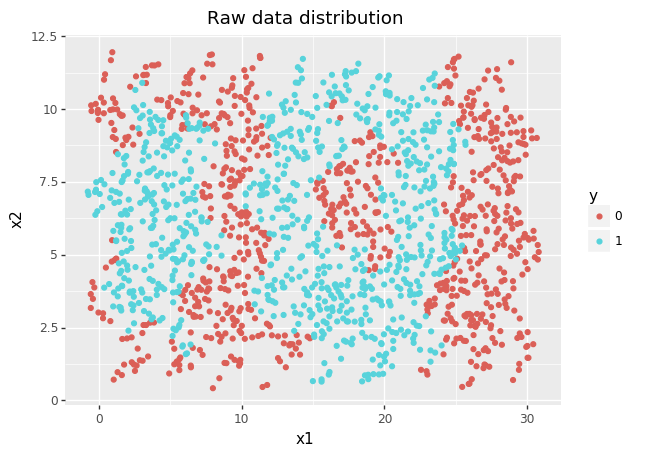

<ggplot: (7566834191)>

In [119]:
gg=pd.DataFrame(np.hstack([xRaw,yRaw]),columns=["x1","x2","y"],dtype ="float64", index=np.arange(1,len(xRaw)+1,1))
gg.x1= pd.to_numeric(gg.x1)
gg.x2= pd.to_numeric(gg.x2)
gg.y = pd.Categorical(gg.y)
pln.ggplot(data=gg)+pln.geom_point(pln.aes(x="x1",y="x2",colour="y"))+pln.labels.ggtitle("Raw data distribution")

We then **split** our raw dataset into Train and Test sets. The scatter plot of the labeled train data shows that we have extracted a random set that has the same distribution of the raw data.

1-labeled data = 802.000000 , 0-labeled data = 798.000000  
true proportion test/wholeData = 0.260000


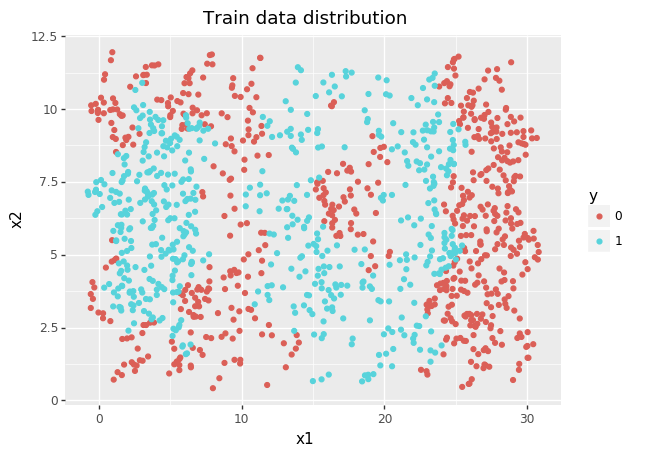

<ggplot: (-9223372029286332128)>

In [120]:
np.random.seed(1995)
proportion = 9/10 
centerSplit = np.array([15,6])
resample = np.random.choice(np.arange(0,N), size=N, replace=False)
X=xRaw[resample,]
Y=yRaw[resample,]
print("1-labeled data = %f , 0-labeled data = %f  "%(np.sum(Y==1), np.sum(Y==0)))

XTest = list()
YTest = list()
XTrain = list()
YTrain = list()

doIt = -1
for i in range(int(N*proportion)):
    if 2< distFromCenter(X[i,],center=centerSplit) < 8 and doIt==1:
        XTest.append(X[i,])
        YTest.append(Y[i,])
        
    else:
        XTrain.append(X[i,])
        YTrain.append(Y[i,])
        doIt = doIt*(-1)

for i in range(int(N*proportion),N):
    XTrain.append(X[i,])
    YTrain.append(Y[i,])

XTrain = np.array(XTrain)
YTrain = np.array(YTrain)
XTest = np.array(XTest)
YTest = np.array(YTest)

print("true proportion test/wholeData = %f"%(len(YTest)/(len(YTest)+len(YTrain))))

#Scatter plot of training data    
gg=pd.DataFrame(np.hstack([XTrain,YTrain]),columns=["x1","x2","y"],dtype ="float64", index=np.arange(1,len(XTrain)+1,1))
gg.x1= pd.to_numeric(gg.x1)
gg.x2= pd.to_numeric(gg.x2)
gg.y = pd.Categorical(gg.y)
pln.ggplot(data=gg)+pln.geom_point(pln.aes(x="x1",y="x2",colour="y"))+pln.labels.ggtitle("Train data distribution")





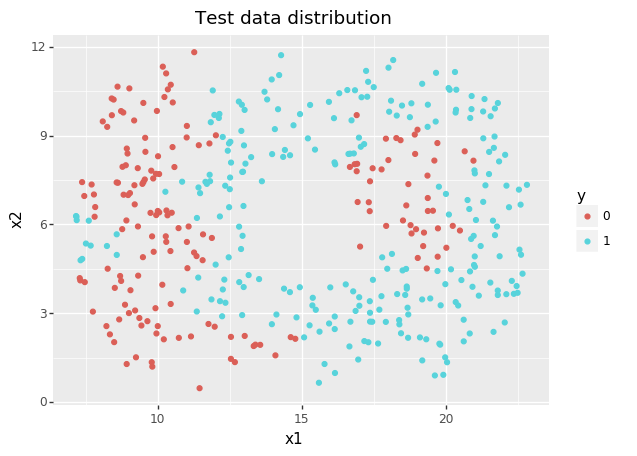

<ggplot: (7569541135)>

In [121]:
#Scatter plot of test data
gg=pd.DataFrame(np.hstack([XTest,YTest]),columns=["x1","x2","y"],dtype ="float64", index=np.arange(1,len(XTest)+1,1))
gg.x1= pd.to_numeric(gg.x1)
gg.x2= pd.to_numeric(gg.x2)
gg.y = pd.Categorical(gg.y)
pln.ggplot(data=gg)+pln.geom_point(pln.aes(x="x1",y="x2",colour="y"))+pln.labels.ggtitle("Test data distribution")

To help the model train and converge more efficiently, we scale-up our data (both train and test sets) to have a zero mean and a Unit Standard Deviation.  

In [110]:
Std0, Std1 =np.std(XTrain[:,0]), np.std(XTrain[:,1])
mu0, mu1 = np.mean(XTrain[:,0]), np.mean(XTrain[:,1])
XTrain[:,0] = (XTrain[:,0]-mu0)/Std0
XTrain[:,1] = (XTrain[:,1]-mu1)/Std1

XTest[:,0] = (XTest[:,0]-mu0)/Std0
XTest[:,1] = (XTest[:,1]-mu1)/Std1

print(XTest.shape)
print(XTrain.shape)

(416, 2)
(1184, 2)


## 2 - Logistic Regression Model
The logistic regression model we build here will serve as a benchmark for our NN classification model.

In [123]:
g0 = tf.Graph()
with g0.as_default():
    with tf.name_scope("placeholders"):
        x=tf.placeholder(dtype=tf.float32,shape=(None,XTrain.shape[1]), name='input')
        y=tf.placeholder(dtype=tf.float32,shape=(None,1), name="output")

    with tf.name_scope("variables"):
        W=tf.Variable(tf.truncated_normal(shape=(XTrain.shape[1],1)), dtype=tf.float32)
        b=tf.Variable(tf.truncated_normal(shape=[1]), dtype=tf.float32)
    
    with tf.name_scope("prediction"):
        logit = tf.matmul(x,W)+b
        outProb=tf.sigmoid(logit)
        outPut = tf.round(outProb)

    with tf.name_scope("loss"):
        entropia=tf.nn.sigmoid_cross_entropy_with_logits(logits=logit, labels=y)
        l=tf.reduce_mean(entropia)
    with tf.name_scope("optimizer"):
        train_op=tf.train.AdagradOptimizer(learnRate).minimize(l)
    initIt=tf.global_variables_initializer()


step : 0 with loss : 3.863221
step : 1000 with loss : 0.659053
step : 2000 with loss : 0.658055
step : 3000 with loss : 0.657151
step : 4000 with loss : 0.656309
step : 5000 with loss : 0.655526
step : 6000 with loss : 0.654795
step : 7000 with loss : 0.654114
step : 8000 with loss : 0.653479
step : 9000 with loss : 0.652886
step : 10000 with loss : 0.652333
step : 11000 with loss : 0.651816
step : 12000 with loss : 0.651332
step : 13000 with loss : 0.650881
step : 14000 with loss : 0.650458
step : 15000 with loss : 0.650063
step : 16000 with loss : 0.649693
step : 17000 with loss : 0.649346
step : 18000 with loss : 0.649022
step : 19000 with loss : 0.648718
step : 20000 with loss : 0.648434
step : 21000 with loss : 0.648167
step : 22000 with loss : 0.647917
step : 23000 with loss : 0.647683
step : 24000 with loss : 0.647463
step : 25000 with loss : 0.647257
step : 26000 with loss : 0.647064
step : 27000 with loss : 0.646882
step : 28000 with loss : 0.646712
step : 29000 with loss : 0.

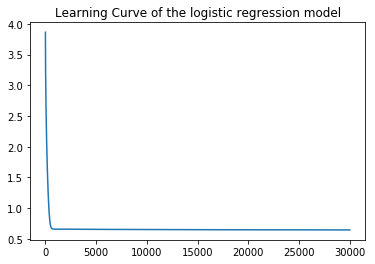

In [124]:
#Training Parameters 
n_iter = 30000

Sess = tf.Session(graph=g0)
with tf.Session(graph=g0) as Sess:
    losses=list()              #List of cost function's values
    Sess.run(initIt)
    feed_dict={x:XTrain,y:YTrain}
    for i in range(n_iter):
        _, loss = Sess.run([train_op, l], feed_dict=feed_dict)
        losses.append(loss)
        if i%1000==0:
            print("step : %d with loss : %f"%(i, loss))
    #Optimal Learned Parameters    
    w_final, b_final= Sess.run([W, b])
    #Predicting on train Data using optimal learned parameters
    y_pred = Sess.run(outPut, feed_dict={x: XTrain})
    #Computing Train/Test Accuracies 
    accuracyTrain1 = np.sum(y_pred==YTrain)/len(YTrain)
    testPred = Sess.run(outPut, feed_dict = {x: XTest})  
    accuracyTest1 = np.sum(testPred==YTest)/len(YTest)
    print("Train Accuracy = %f"%accuracyTrain1)
    print("Test Accuracy = %f"%accuracyTest1)
    #Plotting the Learning Curve
    plt.title("Learning Curve of the logistic regression model")
    plt.plot(losses)

With a train and Test accuracies close to 50% (which is the original proportion of each category-label of our toy dataset), the logistic regression can be considered as a poor and meaningless classifier in this case. The results were expected in fact because of the non-linear shape of the expected boundaries. We will see in the next session that NN handle non-linearities in an efficient way.

## 2 -  Fully Connected (Basic) Deep Neural Network 
The 4-layer NN model will have the structure bellow :  
LINEAR > RELU > LINEAR > RELU > LINEAR > RELU > LINEAR > SIGMOID

In [114]:
#Model Parameters
learnRate = 0.01
layers_dims = [XTrain.shape[1], 10, 10, 10 ,1]      #Number of hidden units per layer

#Building Graph
g1 = tf.Graph()
with g1.as_default():
    with tf.name_scope("placeholders"):
        x=tf.placeholder(dtype=tf.float32,shape=(None,XTrain.shape[1]), name='input')
        y=tf.placeholder(dtype=tf.float32,shape=(None,1), name="output")
        
    with tf.name_scope("hLayer1"):
        W1=tf.Variable(tf.truncated_normal((layers_dims[0], layers_dims[1]), seed=19))
        B1=tf.Variable(tf.random_normal((layers_dims[1],)))
        Z1=tf.matmul(x,W1)+B1
        A1=tf.nn.relu(Z1)
        
    with tf.name_scope("hLayer2"):
        W2=tf.Variable(tf.truncated_normal((layers_dims[1], layers_dims[2]), seed=91), dtype=tf.float32)
        B2=tf.Variable(tf.random_normal((layers_dims[2],)))
        Z2=tf.matmul(A1,W2)+B2
        A2=tf.nn.relu(Z2)
        
    with tf.name_scope("hLayer3"):
        W3=tf.Variable(tf.truncated_normal((layers_dims[2], layers_dims[3]), seed=95), dtype=tf.float32)
        B3=tf.Variable(tf.random_normal((layers_dims[3],)))
        Z3=tf.matmul(A2,W3)+B3
        A3=tf.nn.relu(Z3)        
        
    with tf.name_scope("outLayer"):
        W4=tf.Variable(tf.truncated_normal((layers_dims[3], layers_dims[4]), seed=20), dtype=tf.float32)
        B4=tf.Variable(tf.random_normal((layers_dims[4],)))
        Z4=tf.matmul(A3,W4)+B4
        outProb=tf.sigmoid(Z4)
        outPutIt = tf.round(outProb)

    with tf.name_scope("loss"):
        entropia=tf.nn.sigmoid_cross_entropy_with_logits(logits=Z4, labels=y)
        l=tf.reduce_mean(entropia)
    with tf.name_scope("optimizer"):
        train_op=tf.train.AdamOptimizer(learnRate).minimize(l)

    with tf.name_scope("summaries"):
        tf.summary.scalar("loss",l)
        merged=tf.summary.merge_all()

    train_writer=tf.summary.FileWriter('/tmp/myTBSummary', tf.get_default_graph()) 
    initIt=tf.global_variables_initializer()

We run the Computational graph of our NN model using Batch-processing (whole training set at once). The values of the cost function will be recorded in a list to display the learning curve in the end. The summary of the graph is also stored to access more informations about the graph using TensorBoard.

step : 0 with loss : 16.502600
step : 1000 with loss : 0.213585
step : 2000 with loss : 0.147103
step : 3000 with loss : 0.124932
step : 4000 with loss : 0.115663
step : 5000 with loss : 0.105926
step : 6000 with loss : 0.117784
step : 7000 with loss : 0.113283
step : 8000 with loss : 0.110048
step : 9000 with loss : 0.105471
step : 10000 with loss : 0.100115
step : 11000 with loss : 0.096998
step : 12000 with loss : 0.111773
step : 13000 with loss : 0.092306
step : 14000 with loss : 0.090961
step : 15000 with loss : 0.102265
step : 16000 with loss : 0.096875
step : 17000 with loss : 0.106138
step : 18000 with loss : 0.088103
step : 19000 with loss : 0.088916
step : 20000 with loss : 0.087252
step : 21000 with loss : 0.095053
step : 22000 with loss : 0.091520
step : 23000 with loss : 0.090507
step : 24000 with loss : 0.090218
step : 25000 with loss : 0.090130
step : 26000 with loss : 0.087373
step : 27000 with loss : 0.091673
step : 28000 with loss : 0.094220
step : 29000 with loss : 0

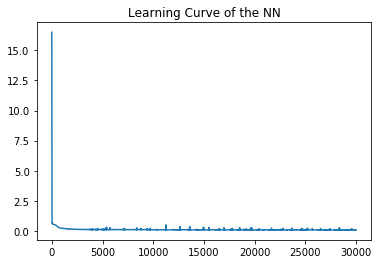

In [115]:
#Training Parameters 
n_epoches = 30000

Sess=tf.Session(graph=g1)
with tf.Session(graph=g1) as Sess:
    lossa=list()              #List of cost function's values
    Sess.run(initIt)
    feed_dict={x:XTrain,y:YTrain}
    for i in range(n_epoches):
        _, summary, loss = Sess.run([train_op, merged, l], feed_dict=feed_dict)
        lossa.append(loss)
        train_writer.add_summary(summary,i)
        if i%1000==0:
            print("step : %d with loss : %f"%(i, loss))
    #Optimal Learned Parameters    
    w1_final, b1_final, W2_final, b2_final, W3_final, b3_final = Sess.run([W1, B1,W2,B2, W3, B3])
    #Predicting on train Data using optimal learned parameters
    y_pred = Sess.run(outPutIt, feed_dict={x: XTrain})
    #Computing Train/Test Accuracies 
    accuracyTrain1 = np.sum(y_pred==YTrain)/len(YTrain)
    testPred = Sess.run(outPutIt, feed_dict = {x: XTest})  
    accuracyTest1 = np.sum(testPred==YTest)/len(YTest)
    print("Train Accuracy = %f"%accuracyTrain1)
    print("Test Accuracy = %f"%accuracyTest1)
    #Plotting the Learning Curve
    plt.title("Learning Curve of the NN")
    plt.plot(lossa)

We obtain a Train and Test accuracies superior than 90%. The Train accuracy is slightly superior than Test accuracy, the model can be improved using regularization methods (drop-out, L2-regularization, batch-Norm...).